In [115]:
library(ggplot2)
library(randomForest)
library(rpart)
library(e1071)
library(DMwR)
library(ROCR)

options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

In [116]:
df.train <- read.csv('./hw2/training.csv', sep = ',')
df.test <- read.csv('./hw2/testing.csv', sep = ',')

In [117]:
colnames(df.train)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

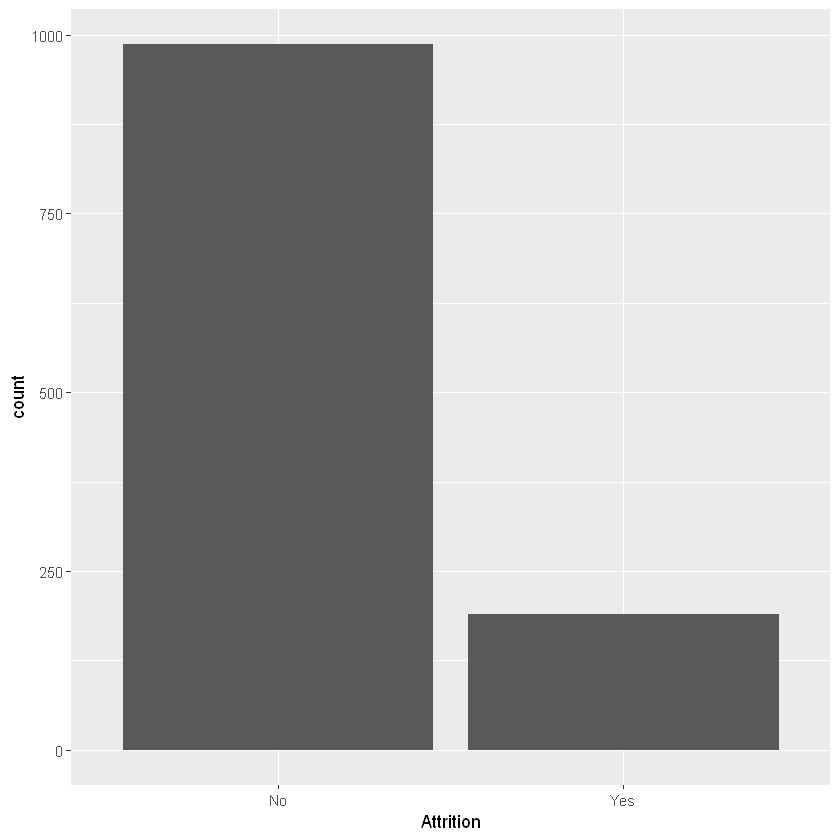

In [118]:
ggplot(df.train, aes(x = Attrition)) + geom_bar()

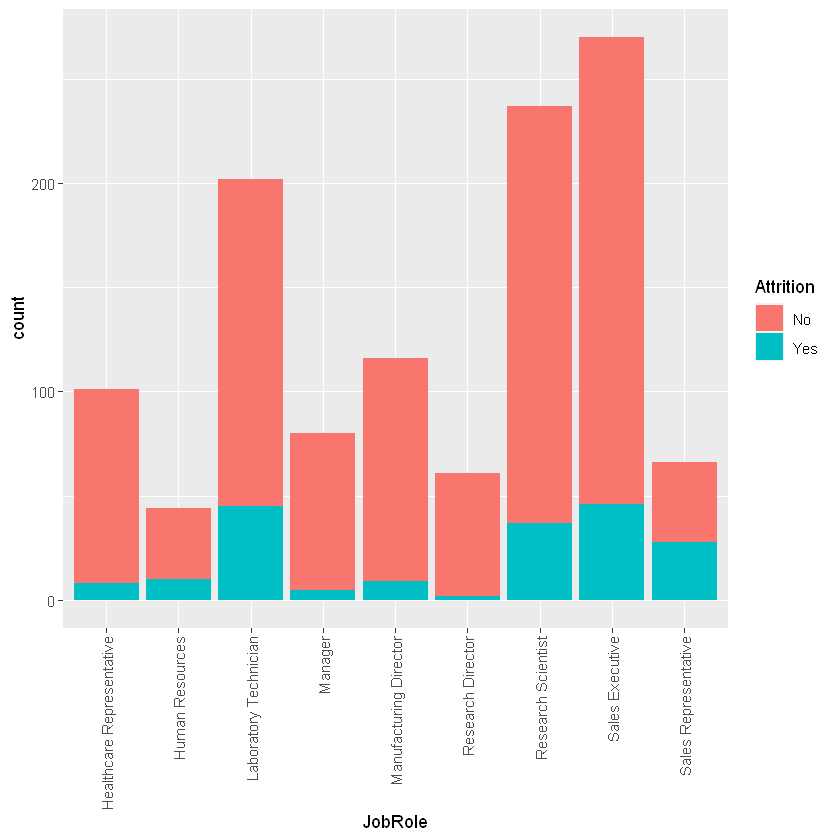

In [119]:
ggplot(df.train, aes(x = JobRole, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

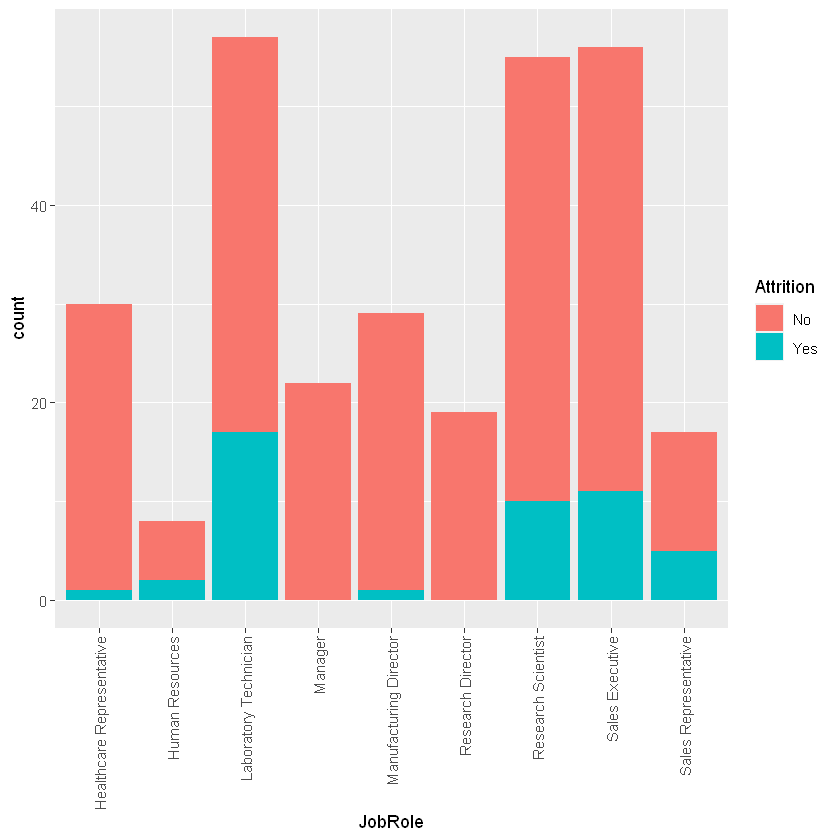

In [120]:
ggplot(df.test, aes(x = JobRole, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [121]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    if(is.factor(df[, col])){
      df[, col] <- as.numeric(as.character(df[, col]))
    }else{
      df[, col] <- as.numeric(df[, col])      
    }
  } 
  return (df)
}
set_col_to_category <- function(df, old_col, new_col, mapper){
  df[new_col] <- as.factor(mapper(df[old_col]))
  return(df)
}
set_col_to_numerical_factor <- function(df, old_col, new_col) {
  df[, new_col] <- as.factor(as.numeric(as.factor(df[, old_col])))
  return(df)
}
set_col_to_log <- function(df, old_col, new_col){
  df[, new_col] <- df[, old_col]
  df[df[new_col]==0, new_col] <- 0.01
  df[, new_col] <- log10(df[, new_col])
  return(df)
}
set_col_to_scale <- function(df, old_col, new_col){
  df[, new_col] <- scale(df[, old_col])
  return(df)
}

In [122]:
build_fold_indices <- function(fold) {
  valid_fold <- 1:fold
  fold_indices <- data.frame(valid = valid_fold)
  return(fold_indices)
}
pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  indices <- unique(indices)
  return(indices)
}
get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  return(excluded)
}
get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  return(included)
}
subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, 'valid'])
  validation_frame <- get_by_index(df, fold, indices[index, 'valid'])
  return(list(training=training_frame,
              validation=validation_frame))
}
shuffle_frame <- function(df){
   set.seed(28657)
   shf_rows <- sample(nrow(df))
   shf_train <- df[shf_rows, ]
   return(shf_train)
}
remove_cols <- function(df, ...){
  cols <- unlist(list(...))
  new_df <- df[, !(names(df) %in% cols)]
  return(new_df)
}

In [123]:
gender_mapper <- function(gender){
  return(ifelse(gender == 'Male', 1, 0))
}
age_mapper <- function(age) {
  return(ifelse(age <= 30, 2,
         ifelse((31<= age && age <= 45), 3,
         ifelse(age <= 45, 1, 0))))
}
travel_mapper <- function(travel) {
  return(ifelse(travel=='Travel_Rarely', 3,
         ifelse(travel=='Travel_Frequently', 2,
         ifelse(travel=='Non-Travel', 1, 0))))
}
department_mapper <- function(department){
  return(ifelse(department=='Human Resources', 1,
         ifelse(department=='Sales', 2,
         ifelse(department=='Research & Development', 3, 0))))
}
field_mapper <- function(field) {
  # 'Medical''Other''Marketing''Human Resources''Technical Degree'
  return(ifelse(field=='Medical', 1, 
         ifelse(field=='Other', 2,
         ifelse(field=='Marketing', 3,
         ifelse(field=='Human Resources', 4,
         ifelse(field=='Technical Degree', 5, 0))))))
}
marital_mapper <- function(marital){
  return(ifelse(marital=='Single', 1,
         ifelse(marital=='Married', 2,
         ifelse(marital=='Divorced', 3, 0))))
}
attrition_mapper <- function(attrition){
  return(ifelse(attrition=='Yes', 1, 0))
}

In [124]:
train_dt <- function(df, depth=5) {
  model <- rpart(
    Target ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_frame <- predict(model, df, type = "class")
  return (pred_frame)
}

In [125]:
train_rf <- function(df, mtry=9) {
   model <- randomForest(
     Target ~ .,
     data = df,
     mtry = mtry,
     importance=TRUE,
     proximity=TRUE,
     ntree=500)
   return (model)
 }
 predict_rf <- function(model, df) {
   pred_frame <- predict(model, df)
   return (pred_frame)
 }

In [126]:
train_lg <- function(df) {
  model <- glm(
    Target ~ .,
    data = df,
    family = "binomial")
  return (model)
}

predict_lg <- function(model, df, attrition_rate=0.5) {
  pred <- predict(model, df, type="response")
  pred_frame <- ifelse(pred > attrition_rate, 1, 0)  
  return (pred_frame)
}

In [127]:
train_sv <- function(df, kernel='linear') {
  model <- svm(
    Target ~ .,
    data = df,
    kernel = kernel)
  return (model)
}
predict_sv <- function(model, df) {
  pred_frame <- predict(model, df)
  return (pred_frame)
}

In [137]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Target,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}
cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}
get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}
cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}
cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}
cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}
cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}
cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}
evaluate_model <- function(df, pred){
  predict_cm <- build_cm(df, pred)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  #ref: https://rstudio-pubs-static.s3.amazonaws.com/309517_9364c67edcae414cab8cd9fffcc89a43.html
  #roc_pred <- prediction(pred, df$Target)
  #auc <- performance(roc_pred, measure = 'auc')
  
  return(list(cm=predict_cm,
              result=predict_result,
              accuracy=accu,
              recall=recl,
              precision=preci,
              sensitivity=sens,
              specificity=spec,
              F1=f1))
}

In [138]:
wrangling_process <- function(df){
  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  df <- set_col_to_numerical_factor(df, 'JobRole', 'JobRole_1')
  df <- set_col_to_category(df, 'MaritalStatus', 'MaritalStatus_1', marital_mapper)
  df <- set_col_to_category(df, 'Attrition', 'Target', attrition_mapper)
  df <- set_col_to_log(df, 'MonthlyIncome', 'MonthlyIncome_1')
  df <- set_col_to_scale(df, 'TotalWorkingYears', 'TotalWorkingYears_1')
  df <- set_col_to_scale(df, 'YearsAtCompany', 'YearsAtCompany_1')
  df <- set_col_to_scale(df, 'YearsInCurrentRole', 'YearsInCurrentRole_1')
  df <- set_col_to_scale(df, 'YearsSinceLastPromotion', 'YearsSinceLastPromotion_1')
  df <- set_col_to_scale(df, 'YearsWithCurrManager', 'YearsWithCurrManager_1')
  
  df <- remove_cols(df, 'Gender', 'Age', 'BusinessTravel', 'Department', 
                    'EducationField', 'JobRole', 'EmployeeNumber', 'MaritalStatus', 'Attrition',
                    'MonthlyIncome', 'EmployeeNumber',
                    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
                    'YearsSinceLastPromotion', 'YearsWithCurrManager')
  
  return(df)
}

df.procd <- shuffle_frame(wrangling_process(df.train))
head(df.procd)
summary(df.procd)

,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Target,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
631,25,3,1,2,1,2,4,4,2,0,0,3,1,3,3,3,1,7,1,1,3.364176,-0.8076522,-0.8220256,-0.6211184,-0.05438851,-0.60477306
408,3,1,4,4,2,4,1,4,2,2,3,3,0,2,2,2,1,8,3,0,3.667173,-0.6770923,-0.1761483,0.1996784,-0.68198924,-0.04888248
526,14,1,3,3,2,4,0,3,1,1,2,2,1,3,3,3,0,1,2,0,3.818622,0.7590666,1.4385448,1.0204752,0.57321223,1.89673455
587,2,4,1,3,2,4,0,3,2,1,2,3,0,2,3,3,0,5,2,0,3.626032,-0.9382121,-0.6605563,-0.6211184,-0.05438851,-0.60477306
103,20,3,2,1,2,3,3,3,3,1,2,3,0,3,3,2,0,8,2,1,3.658870,-0.9382121,-0.8220256,-0.6211184,-0.05438851,-0.60477306
406,1,4,2,1,1,4,1,3,4,1,5,3,1,2,2,3,0,7,3,0,3.434569,-0.1548527,0.4697289,0.7468763,-0.05438851,1.06289868


 DistanceFromHome   Education     EnvironmentSatisfaction JobInvolvement 
 Min.   : 1.000   Min.   :1.000   Min.   :1.000           Min.   :1.000  
 1st Qu.: 2.000   1st Qu.:2.000   1st Qu.:2.000           1st Qu.:2.000  
 Median : 7.000   Median :3.000   Median :3.000           Median :3.000  
 Mean   : 9.034   Mean   :2.926   Mean   :2.728           Mean   :2.723  
 3rd Qu.:13.000   3rd Qu.:4.000   3rd Qu.:4.000           3rd Qu.:3.000  
 Max.   :29.000   Max.   :5.000   Max.   :4.000           Max.   :4.000  
                                                                         
    JobLevel     JobSatisfaction NumCompaniesWorked PerformanceRating
 Min.   :1.000   Min.   :1.000   Min.   :0.000      Min.   :3.000    
 1st Qu.:1.000   1st Qu.:2.000   1st Qu.:1.000      1st Qu.:3.000    
 Median :2.000   Median :3.000   Median :2.000      Median :3.000    
 Mean   :2.066   Mean   :2.691   Mean   :2.679      Mean   :3.144    
 3rd Qu.:3.000   3rd Qu.:4.000   3rd Qu.:4.000      3rd Qu

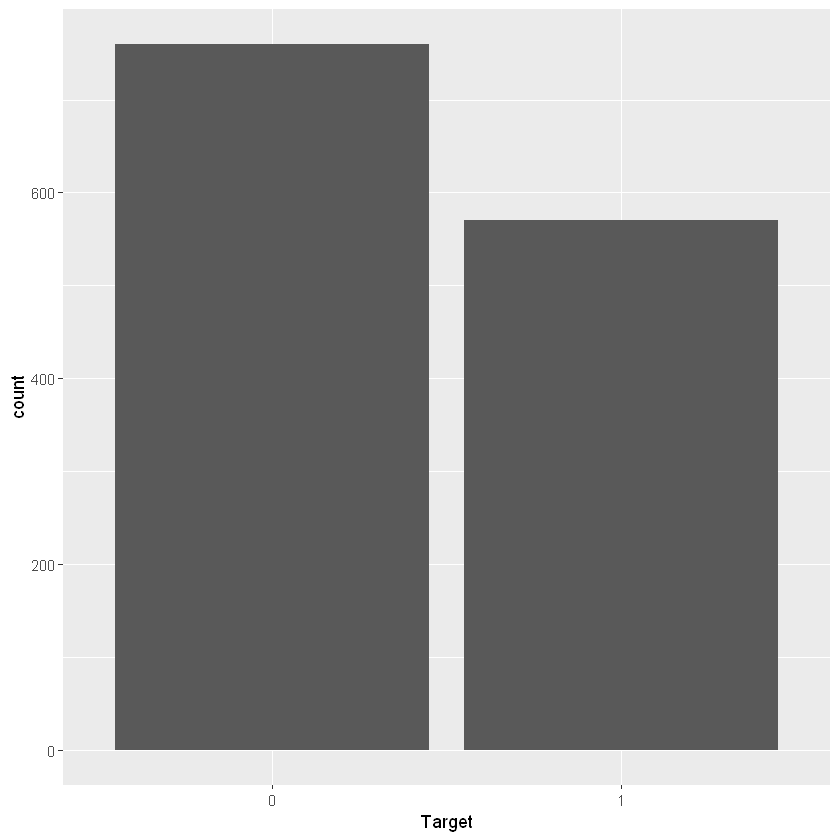

,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Target,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
772,4,4,3,3,2,3,1,3,2,0,3,3,1,3,2,3,0,7,1,0,3.628287,-0.2854126,0.3082596,0.47327736,-0.36818888,-0.8827183
79,10,4,4,3,4,3,0,3,3,0,1,2,1,3,3,2,1,8,1,0,4.142139,3.5008244,4.8294004,1.56767314,-0.36818888,1.0628987
512,8,3,1,3,4,4,5,3,3,1,3,3,1,3,3,2,3,8,2,0,4.073205,2.1952254,-0.8220256,-1.16831631,-0.05438851,-0.6047731
57,1,3,2,3,1,1,4,3,4,1,2,2,1,3,2,3,1,7,2,0,3.341237,-0.8076522,-0.6605563,-0.62111842,-0.36818888,-0.6047731
557,8,2,3,3,3,3,5,3,1,1,2,4,1,2,3,2,2,8,3,0,3.861176,-0.1548527,0.1467903,-0.07392053,1.51461333,0.7849534
983,2,3,3,3,3,4,4,3,2,1,5,2,1,3,3,2,0,8,3,0,4.015695,0.2368270,0.4697289,0.47327736,-0.68198924,-0.3268278


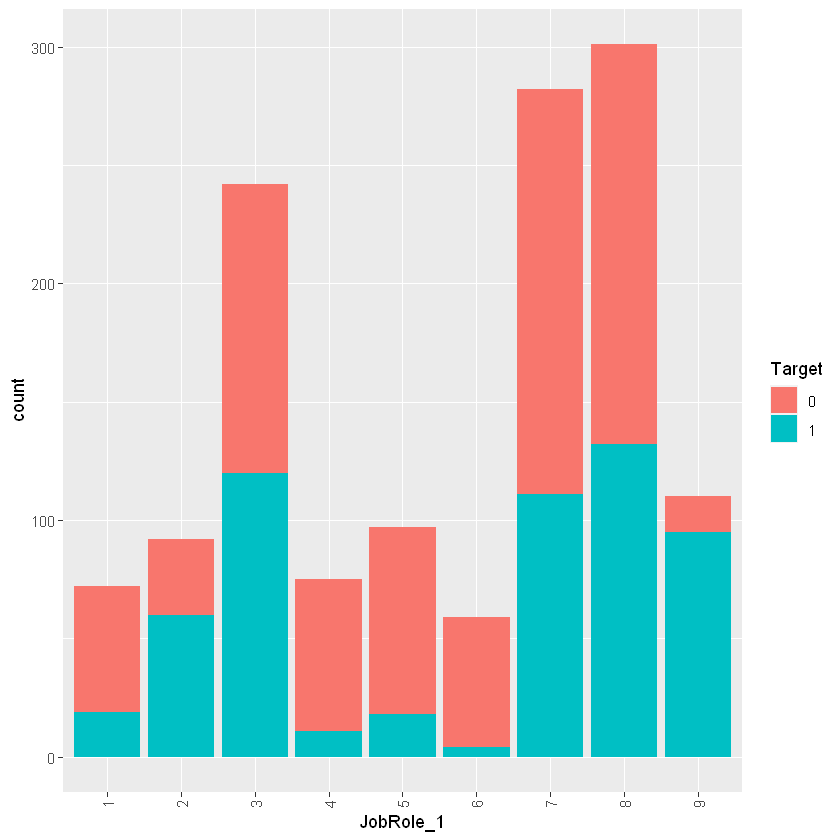

In [139]:
fold <- 3
index <- 2
df.rsmpl <- SMOTE(Target ~ ., df.procd, perc.over = 200, perc.under=200)
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df.rsmpl, fold, index, fold_indices)
ggplot(df.rsmpl, aes(x = Target)) + geom_bar()
ggplot(df.rsmpl, aes(x = JobRole_1, fill = Target)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
head(splitted_frames$training)

In [140]:
# trainer <- (function(df) train_rf(df, 8))
# predictor <- (function(model, df) predict_rf(model, df))
trainer <- (function(df) train_sv(df, kernel='sigmoid'))
predictor <- (function(model, df) predict_sv(model, df))

model <- trainer(splitted_frames$training)

print('train result:')
pred_train <- predictor(model, splitted_frames$training)
result_train <- evaluate_model(splitted_frames$training, pred_train)
print(result_train)
              
print('validation:')
pred_valid <- predictor(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
print(result_valid)

[1] "train result:"
$cm
     pred
truth   0   1
    0 424  83
    1 109 271

$result
 TP  FP  TN  FN 
271  83 424 109 

$accuracy
[1] 0.78

$recall
[1] 0.71

$precision
[1] 0.77

$sensitivity
[1] 0.71

$specificity
[1] 0.84

$F1
[1] 0.74

[1] "validation:"
$cm
     pred
truth   0   1
    0 211  42
    1  57 133

$result
 TP  FP  TN  FN 
133  42 211  57 

$accuracy
[1] 0.78

$recall
[1] 0.7

$precision
[1] 0.76

$sensitivity
[1] 0.7

$specificity
[1] 0.83

$F1
[1] 0.73



In [141]:
print('testing:')
model.rsmpl <- trainer(df.rsmpl)
df.test2 <- wrangling_process(df.test)
pred_test <- predictor(model.rsmpl, df.test2)
result_test <- evaluate_model(df.test2, pred_test)
print(result_test)

[1] "testing:"
$cm
     pred
truth   0   1
    0 197  49
    1  21  26

$result
 TP  FP  TN  FN 
 26  49 197  21 

$accuracy
[1] 0.76

$recall
[1] 0.55

$precision
[1] 0.35

$sensitivity
[1] 0.55

$specificity
[1] 0.8

$F1
[1] 0.43

